# ResNet-18

# 1. Imports

In [2]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# create datasets using `ImageFolder`
from torchvision.datasets import ImageFolder
# import compose and other transformations
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop
# plotting
import matplotlib.pyplot as plt


# for file paths
import os
# for time
import time
# for copying
import copy

In [15]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# checks whether CUDA is available
# print(torch.cuda.is_available())

# setting the device to "cuda" instead of default "cpu"
# device = torch.device("cuda" if torch.cuda.is_available else "cpu")

# setting the device to "cpu"
# device = torch.device("cpu")

True
True


In [4]:
# check the device
device

device(type='mps')

# 2. Preparing Data

In this case we use the in-built `CIFAR10` dataset provided by PyTorch. This has `60000`, `32 * 32` color images in `10` with approximately `1000` images per class.

In [50]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Resize, CenterCrop, ToTensor, Normalize

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    # train transform
    'train': Compose([
        #RandomResizedCrop(224),
        #RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean, std)
    ]),
    # test transform
    'test': Compose([
        #Resize(256),
        #RandomResizedCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ])
}

In [51]:
str_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [52]:
# some hyper-parameters
batch_size = 5
num_epochs = 10
learning_rate = 0.001

In [65]:
# MNIST dataset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# train
# keep download=True, the first time
'''
train_dataset = CIFAR10(
    root='./data/CIFAR10/',
    train=True,
    transform=data_transforms['train'],
    download=True
)
'''
train_dataset = CIFAR10(
    root='./data/CIFAR10/',
    train=True,
    transform=data_transforms['train'],
    download=False
)


# test
test_dataset = CIFAR10(
    root='./data/CIFAR10/',
    train=False,
    transform=data_transforms['test']
    # don't have to download again
)

# DataLoader

#train
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

#test
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=len(test_dataset),
    shuffle=False
)

image_dataloaders = {
    'train': train_loader,
    'test': test_loader
}

Let's analyse the data.

In [54]:
# extracting the test dataset
X_test, y_test = next(iter(test_loader))
# move the data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)
# print the shape
print(X_test.shape, y_test.shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


So, we have `10000` examples in our test set, which are `32*32` triple-channeled colored images. We try visualizing these images:

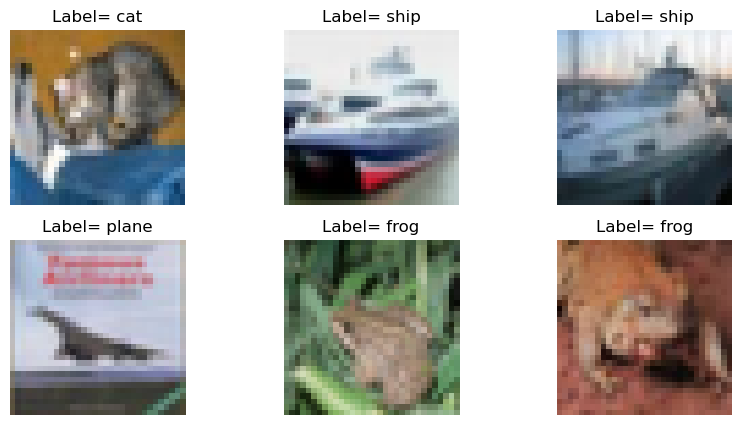

In [80]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= " + str_labels[y_test[i].item()])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Model
![](https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)

![](https://debuggercafe.com/wp-content/uploads/2022/08/resnet18-basic-blocks-1.png)

Code Source: [Article1](https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/), [Article2](https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch)

In [8]:
# defining the repeating basic block
# each basic block has 2 convolutional layers
# first convolutional layer is followed by Batch Normalization and ReLU
# second convolutional layer is only followed by Batch Normalization
# we apply a second ReLU after adding the residue with identity

class ResBlock18(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock18, self).__init__()

        # input = i,n,n
        # conv-layer-1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # batch normalization layer
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        # relu
        self.relu = nn.ReLU(inplace=True)

        # input = i,n,n
        # conv-layer-2
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # batch normalization layer
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # if input dim != output dim (happens when stride != 1) we downsample the input using 1x1 conv to the same dim as output
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
    
    def forward(self, X):
        # store/downsample identity
        idn = X
        # input dim != output dim
        if self.downsample is not None:
            idn = self.downsample(idn)
        
        # evaluate residue
        # layer-1
        res = self.relu(self.bn1(self.conv1(X)))
        # layer-2
        res = self.bn2(self.conv2(res))

        
        # add the residue and identity
        out = idn + res
        
        # relu layer
        out = self.relu(out)

        return out

In [9]:
# defining full ResNet-18

class ResNet18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet18, self).__init__()

        # Initial Layers: define the layers before the Residual Layers
        
        # Conv2d->BN->ReLU->Max-Pooling
        # changes the no. of channels to 64
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Layers
        
        # for ResNet18 we have 4 types of Residual Blocks being repeated twice each [2,2,2,2]
        
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, stride=1)

        self.layer2 = self._make_layer(in_channels=64, out_channels=128, stride=2)

        self.layer3 = self._make_layer(in_channels=128, out_channels=256, stride=2)

        self.layer4 = self._make_layer(in_channels=256, out_channels=512, stride=2)

        # Final Layers: define the layers after the Residual Layers

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResBlock18(in_channels=in_channels, out_channels=out_channels, stride=stride),
            ResBlock18(in_channels=out_channels, out_channels=out_channels)
        )
    
    
    def forward(self, X):
        
        # Initial Layers
        out = self.maxpool(self.relu(self.bn1(self.conv1(X))))

        # Residual Layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Final Layers
        out = self.avgpool(out)
        # reshape
        out = out.view(out.shape[0], -1)
        out = self.fc(out)

        return out

Let's initialize the model and test the result of the test dataset.

In [62]:
# define the model
model = ResNet18(image_channels=3, num_classes=10).to(device=device)
# 3 channels: RGB, 10 classes to classify

In [63]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid outputx
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.1047


# 4. Training

In [68]:
from sklearn.metrics import accuracy_score

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20):
    # begin start time to record time-elapsed
    # since = time.time()

    # to return the model with best accuracy
    # variable to store the best model parameters
    best_model_params = copy.deepcopy(model.state_dict())
    # variable to store the best accuracy
    best_acc = 0.0

    # start training epochs
    for epoch in range(num_epochs):

        # each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase=='train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            # iterate over data
            for batch in image_dataloaders[phase]:
                # extract features and labels
                X,y = batch
                # adding to GPU
                X,y = X.to(device), y.to(device)

                # forward
                # track grad iff phase == train
                with torch.set_grad_enabled(phase=='train'):
                    # compute prediction
                    y_pred = model(X)

                    # loss + backward + optimize iff phase = 'train'
                    if phase=='train':
                        # compute loss
                        loss = criterion(y_pred, y)
                        # compute grads
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # zero-gradients after updating
                        optimizer.zero_grad()
                
            # learning scheduler step iff phase == 'train'
            if scheduler and phase=='train':
                # update learning rate
                scheduler.step()
            
            # check accuracy on test set iff phase == 'test'
            if phase=='test':
                _, y_hat = torch.max(y_pred, dim=1)
                epoch_acc = accuracy_score(y.cpu(), y_hat.cpu())

        # update best_model and best accuracy after the epoch
        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_model_params = copy.deepcopy(model.state_dict())
        
        # print epoch info
        print('-----------------------------------------')
        print('Epoch: {}/{}'.format(epoch+1, num_epochs))
        print('Best Test Acc: {:2f}'.format(best_acc))
        # to keep track of time
        '''
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        '''
    

    # post training, load the best_model parameters and output the model

    # load best model weights
    model.load_state_dict(best_model_params)
    return model


In [70]:
# some hyper-parameters
batch_size = 5
num_epochs = 10
learning_rate = 0.001

In [69]:
# define loss
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr = learning_rate,
    momentum=0.9
)

# step Learning Rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10,
    gamma=0.5
)

In [71]:
model = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
)

-----------------------------------------
Epoch: 1/10
Best Test Acc: 0.443800
-----------------------------------------
Epoch: 2/10
Best Test Acc: 0.510200
-----------------------------------------
Epoch: 3/10
Best Test Acc: 0.569300
-----------------------------------------
Epoch: 4/10
Best Test Acc: 0.583700
-----------------------------------------
Epoch: 5/10
Best Test Acc: 0.636200
-----------------------------------------
Epoch: 6/10
Best Test Acc: 0.678000
-----------------------------------------
Epoch: 7/10
Best Test Acc: 0.699300
-----------------------------------------
Epoch: 8/10
Best Test Acc: 0.711300
-----------------------------------------
Epoch: 9/10
Best Test Acc: 0.725400
-----------------------------------------
Epoch: 10/10
Best Test Acc: 0.727600


Saving the model.

In [6]:
model_save_path = os.path.join('models','ResNet18-10E.pth')
model_save_path

'models/ResNet18-10E.pth'

In [73]:
#torch.save(model, model_save_path)

In [10]:
model_main = torch.load(model_save_path)

Saving the paramaeters.

In [1]:
# save params
param_save_path = os.path.join('models', 'ResNet18-10E-params.pt')
param_save_path

'models/ResNet18-10E-params.pt'

In [12]:
# saving the params
torch.save(model_main.state_dict(), param_save_path)

In [14]:
# load model params
model_main = ResNet18(image_channels=3, num_classes=10)
model_main.load_state_dict(torch.load(param_save_path))
model_main.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBlock18(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock18(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


# 5. Evaluation

In [77]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model_main(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.7276


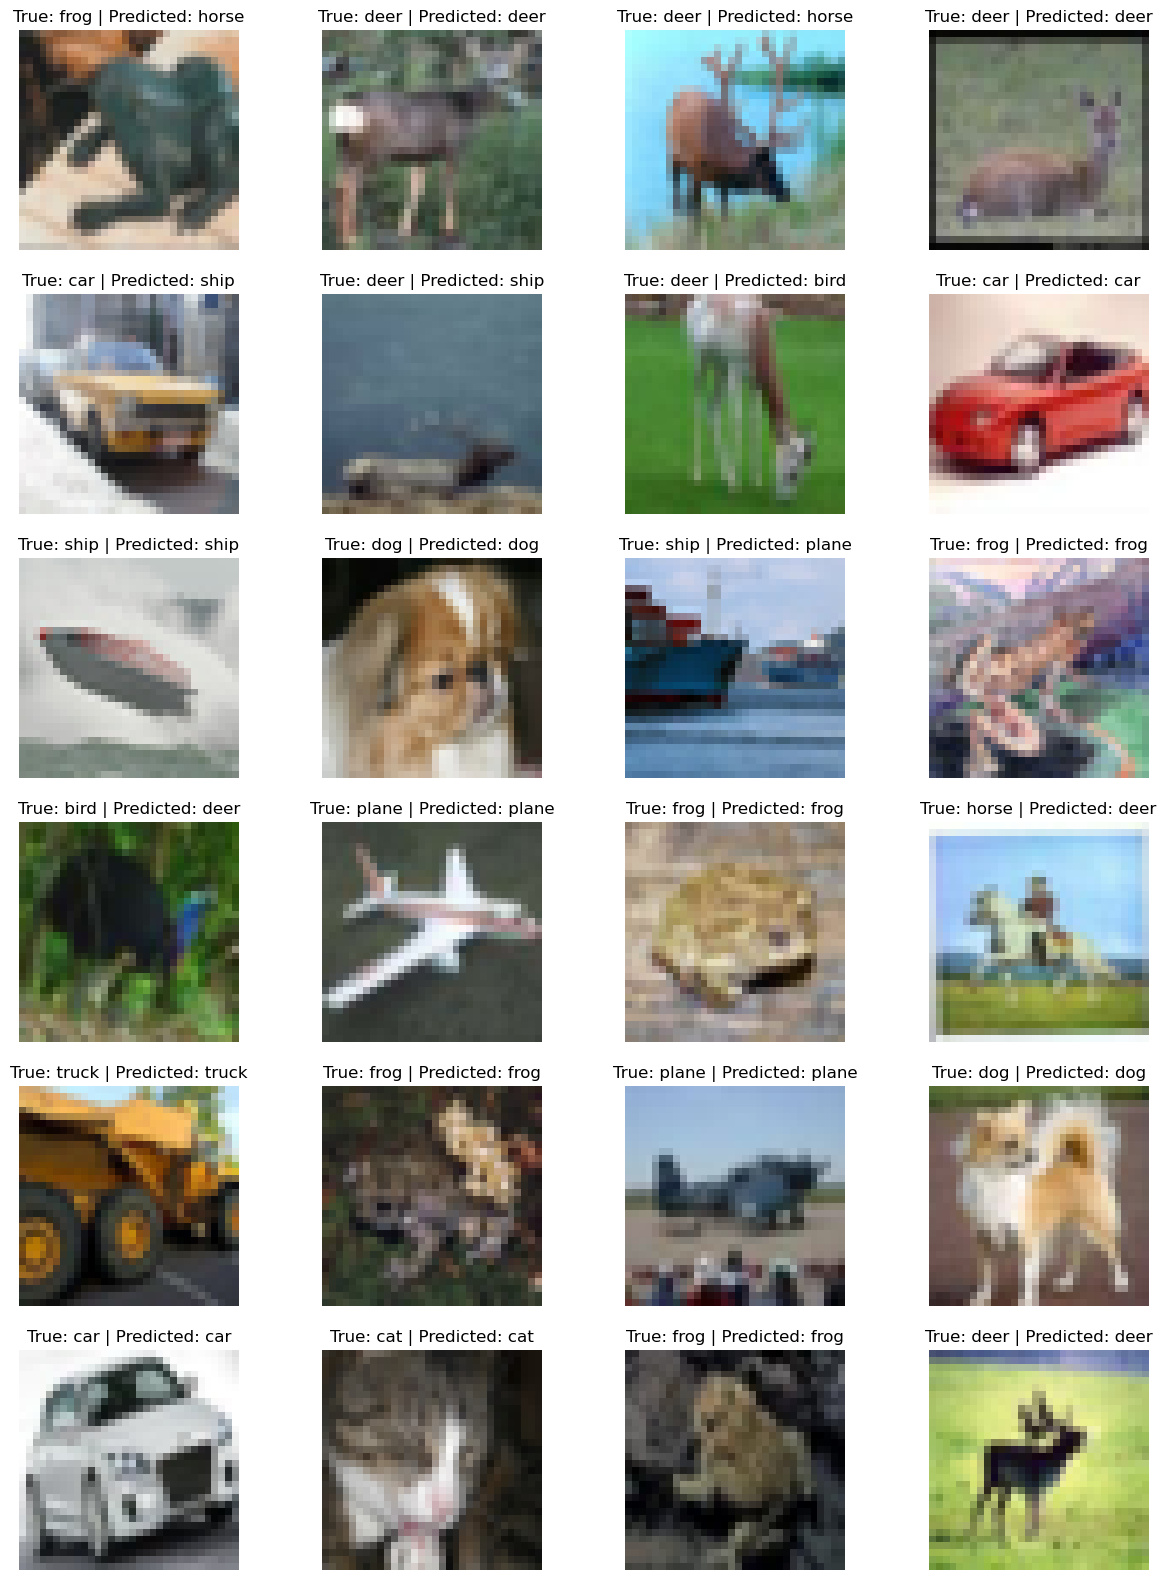

In [82]:
with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model_main(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)


test_idx = np.random.randint(X_test.shape[0] ,size=24)

plt.figure(figsize=(15,20))
for i in range(24):
    plt.subplot(6, 4, i+1)
    # copy the image back to cpu to reshape
    img = X_test[test_idx[i]].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("True: " + str_labels[y_test[test_idx[i]]] + " | Predicted: " + str_labels[y_test_hat[test_idx[i]]])
    plt.grid(False)
    plt.axis(False)
plt.show()